sessid_01_P1_sid_09
sessid_01_P2_sid_02
sessid_02_P1_sid_09
sessid_02_P2_sid_17
sessid_03_P1_sid_17
sessid_03_P2_sid_02
sessid_04_P1_sid_12
sessid_04_P2_sid_23
sessid_05_P1_sid_12
sessid_05_P2_sid_21
sessid_06_P1_sid_23
sessid_06_P2_sid_21
sessid_07_P1_sid_09
sessid_07_P2_sid_01
sessid_08_P1_sid_09
sessid_08_P2_sid_04
sessid_09_P1_sid_01
sessid_09_P2_sid_04
sessid_10_P1_sid_09
sessid_10_P2_sid_34
sessid_11_P1_sid_09
sessid_11_P2_sid_15
sessid_12_P1_sid_15
sessid_12_P2_sid_11
sessid_13_P1_sid_09
sessid_13_P2_sid_19
sessid_14_P1_sid_19
sessid_14_P2_sid_06
sessid_15_P1_sid_09
sessid_15_P2_sid_16
sessid_16_P1_sid_24
sessid_16_P2_sid_16
sessid_17_P1_sid_09
sessid_17_P2_sid_43
sessid_18_P1_sid_03
sessid_18_P2_sid_43
sessid_19_P1_sid_09
sessid_19_P2_sid_22
sessid_20_P1_sid_09
sessid_20_P2_sid_50
sessid_21_P1_sid_50
sessid_21_P2_sid_22
sessid_22_P1_sid_12
sessid_22_P2_sid_18
sessid_23_P1_sid_12
sessid_23_P2_sid_39
sessid_24_P1_sid_18
sessid_24_P2_sid_39
sessid_25_P1_sid_12
sessid_25_P2_sid_27


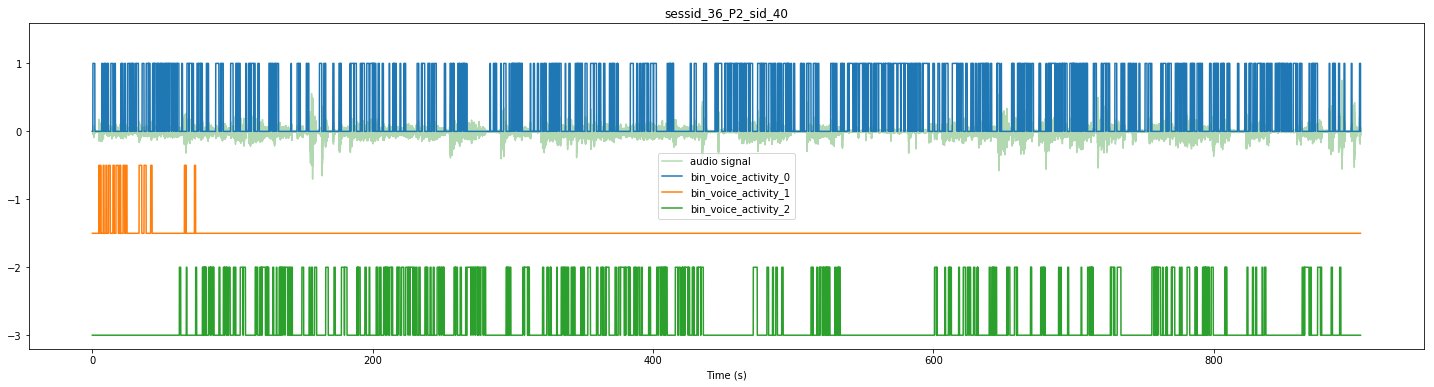

In [2]:
#######################################################################################################################
# Project: Deep Virtual Rapport Agent (rapport model)
#
#     Jan Ondras (jo951030@gmail.com)
#     Institute for Creative Technologies, University of Southern California
#     April-October 2019
#
#######################################################################################################################
# Plot speakers' voice activity using outputs from the IBM Watson speech-to-text service.
#     Plots of binary voice activity and audio waveform for each speaker.
#     Speaker tags assigned by the STT service can be any number!
#     Saved as png plots.
#######################################################################################################################


import json
import glob
import numpy as np
import soundfile as sf
from matplotlib import pyplot as plt


# Path to STT outputs
stt_outputs_dir = f'/home/ICT2000/jondras/dvra_datasets/mimicry/audio/voice_activity_detection/speech_to_text_ibm_watson'
mono_audio_dir = f'/home/ICT2000/jondras/dvra_datasets/mimicry/audio/audio_separated_8kHz'
# mono_audio_dir = '/home/ICT2000/jondras/dvra_datasets/mimicry/audio/audio_separated_16kHz_flac'

# Iterate over JSON output files and audio files
for i, stt_output_file in enumerate(sorted(glob.glob(f'{stt_outputs_dir}/stt_*.json'))):
    
    output_filename_split = stt_output_file.split('/')[-1][:-5].split('_')
    audio_basename = '_'.join(output_filename_split[1:])
    print(audio_basename)
#     if int(audio_basename[7:9]) < 52:
#     if audio_basename != 'sessid_36_P2_sid_40':
#         continue

    # Load audio signal
    audio_signal, samplerate = sf.read(f'{mono_audio_dir}/{audio_basename}.wav')
#     audio_signal, samplerate = sf.read(f'{mono_audio_dir}/{audio_basename}.flac')
    print(f'\tSampling rate: {samplerate}')
    x_audio_signal = np.arange(0, len(audio_signal) / samplerate, 1. / samplerate)[:len(audio_signal)]
    
    # Load JSON output files from STT and generate binary voice activity
    with open(stt_output_file, "r") as json_file:
        data = json.load(json_file)
                
        # Generate binary voice activity
        # Speaker tags can be any number
        bin_voice_activity = dict()
        for active_segment in data['speaker_labels']:
            speaker_tag = int(active_segment['speaker'])
            # Add new speaker tag
            if speaker_tag not in bin_voice_activity.keys():
                bin_voice_activity[speaker_tag] = np.zeros(len(audio_signal), dtype=int)
                if len(bin_voice_activity.keys()) > 2:
                    raise Exception('More than 2 speakers identified!')
            
            bin_voice_activity[speaker_tag] = np.where(
                (x_audio_signal >= active_segment['from']) & (x_audio_signal <= active_segment['to']), 1, 
                bin_voice_activity[speaker_tag])
        print(f'\tSpeaker tags: {bin_voice_activity.keys()}')
    
    # Plot raw audio signal and bin_voice_activity of each speaker
    plt.figure(figsize=[25,6])
    plt.title(audio_basename)
    plt.plot(x_audio_signal, audio_signal, 'g-', alpha=0.3, label='audio signal')#,linewidth=2.0)
    for j, speaker_tag in enumerate(bin_voice_activity.keys()):
        plt.plot(x_audio_signal, bin_voice_activity[speaker_tag] - j*1.5, label=f'bin_voice_activity_{speaker_tag}')#,linewidth=2.0)
#     plt.xlim(110, 135)
#     plt.ylim(-1.6, 1.6)
    plt.ylim(-3.2, 1.6)
    plt.xlabel('Time (s)')
    plt.legend()
    plt.savefig(f'./speaker_diarization_plots_ibm_watson/{audio_basename}.png')
    fig.clear()
    plt.close(fig)
        
print(f'Processed {i + 1} IBM speech2text output files.')


In [1]:
###################################################################################################
# Plot smoothed voice activity of the main speaker (identified manually for each recording). 
#
#     if 2 consecutive voice-active intervals are less than 200 ms apart, join them
#     (based on http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.2.6135&rep=rep1&type=pdf)
# 
#     Requires main_speaker_tag manually identified in speaker_diarization_ibm.csv.
#     Save new plot and csv of smoothed voice activity intervals. 
###################################################################################################

# 200 ms
MAX_WORD_PAUSE_DURATION = 0.2

import json
import glob
import numpy as np
import pandas as pd
import soundfile as sf
from matplotlib import pyplot as plt


# Path to STT outputs
speaker_diarization_csv = f'speaker_diarization_ibm_watson.csv'
voice_activity_dir = f'/home/ICT2000/jondras/dvra_datasets/mimicry/voice_activity_detection/voice_activity_ibm_watson'
stt_outputs_dir = f'/home/ICT2000/jondras/dvra_datasets/mimicry/voice_activity_detection/speech_to_text_ibm_watson'
mono_audio_dir = f'/home/ICT2000/jondras/dvra_datasets/mimicry/audio/audio_separated_8kHz'
# mono_audio_dir = '/home/ICT2000/jondras/dvra_datasets/mimicry/audio/audio_separated_16kHz_flac'

# Iterate over JSON output files and audio files
for i, stt_output_file in enumerate(sorted(glob.glob(f'{stt_outputs_dir}/stt_*.json'))):
    
    output_filename_split = stt_output_file.split('/')[-1][:-5].split('_')
    audio_basename = '_'.join(output_filename_split[1:])
    print(audio_basename)
    if int(audio_basename[7:9]) < 7:
        continue

    # Load audio signal
    audio_signal, samplerate = sf.read(f'{mono_audio_dir}/{audio_basename}.wav')
#     audio_signal, samplerate = sf.read(f'{mono_audio_dir}/{audio_basename}.flac')
    print(f'\tSampling rate: {samplerate}')
    x_audio_signal = np.arange(0, len(audio_signal) / samplerate, 1. / samplerate)[:len(audio_signal)]
    
    # Load main_speaker_tag
    df = pd.read_csv(speaker_diarization_csv)
    main_speaker_tag = int(df[df['filename'] == audio_basename]['main_speaker_tag'])
    
    # Load JSON output files from STT and generate binary voice activity
    with open(stt_output_file, "r") as json_file:
        data = json.load(json_file)
        
        # Generate binary voice activity
        bin_voice_activity = np.zeros(len(audio_signal), dtype=int)
        for active_segment in data['speaker_labels']:                    
            if int(active_segment['speaker']) == main_speaker_tag:
                bin_voice_activity = np.where(
                    (x_audio_signal >= active_segment['from']) & (x_audio_signal <= active_segment['to']), 1, 
                    bin_voice_activity)
        
    # Perform smoothing
    smoothed_bin_voice_activity = np.copy(bin_voice_activity)
    is_pause = False
    for j in range(len(bin_voice_activity) - 1):
        # End of VA interval => will check if there is a next VA interval within 200 ms
        if (bin_voice_activity[j] == 1) and (bin_voice_activity[j + 1] == 0):
            is_pause = True
            pause_start_j = j + 1
        # Start of new VA interval
        elif (bin_voice_activity[j] == 0) and (bin_voice_activity[j + 1] == 1):
            # If there was a pause started and is short enough, join these two VA intervals
            if is_pause and (((j + 1 - pause_start_j) / samplerate) <= MAX_WORD_PAUSE_DURATION):
                smoothed_bin_voice_activity[pause_start_j:j + 1] = 1
            is_pause = False
    
    # Record start and end times of all new voice-active intervals
    smoothed_va_intervals = []
    if smoothed_bin_voice_activity[0] == 1:
        start_time = 0.
    for j in range(len(smoothed_bin_voice_activity) - 1):
        # End of VA interval
        if (smoothed_bin_voice_activity[j] == 1) and (smoothed_bin_voice_activity[j + 1] == 0):
            smoothed_va_intervals.append([start_time, (j + 1) / samplerate])
        # Start of VA interval
        elif (smoothed_bin_voice_activity[j] == 0) and (smoothed_bin_voice_activity[j + 1] == 1):
            start_time = (j + 1) / samplerate
    if smoothed_bin_voice_activity[-1] == 1:
        smoothed_va_intervals.append([start_time, len(smoothed_bin_voice_activity) / samplerate])
    # Check if the smoothing is correct
    assert len([-1 for j in range(len(smoothed_va_intervals) - 1) 
                if (smoothed_va_intervals[j + 1][0] - smoothed_va_intervals[j][1]) <= MAX_WORD_PAUSE_DURATION]) == 0
    # Save csv of smoothed voice activity
    va_df = pd.DataFrame(smoothed_va_intervals, columns=['start_time', 'end_time'])
    va_df.to_csv(f'{voice_activity_dir}/{audio_basename}.csv', index=False)
    
    # Plot raw audio signal and bin_voice_activity  
    fig = plt.figure(figsize=[25,6])
    plt.title(audio_basename)
    plt.plot(x_audio_signal, audio_signal, 'g-', alpha=0.3, label='audio signal')#,linewidth=2.0)
    plt.plot(x_audio_signal, bin_voice_activity - 1.5, label=f'bin_voice_activity')#,linewidth=2.0)
    plt.plot(x_audio_signal, smoothed_bin_voice_activity, label=f'smoothed_bin_voice_activity')#,linewidth=2.0)
    #     plt.xlim(110, 135)
    plt.ylim(-1.6, 1.6)
    plt.xlabel('Time (s)')
    plt.legend()
    plt.savefig(f'{voice_activity_dir}/{audio_basename}.png')
    fig.clear()
    plt.close(fig)
        
print(f'Processed {i + 1} IBM speech2text output files.')

sessid_01_P1_sid_09
sessid_01_P2_sid_02
sessid_02_P1_sid_09
sessid_02_P2_sid_17
sessid_03_P1_sid_17
sessid_03_P2_sid_02
sessid_04_P1_sid_12
sessid_04_P2_sid_23
sessid_05_P1_sid_12
sessid_05_P2_sid_21
sessid_06_P1_sid_23
sessid_06_P2_sid_21
sessid_07_P1_sid_09
	Sampling rate: 8000
sessid_07_P2_sid_01
	Sampling rate: 8000
sessid_08_P1_sid_09
	Sampling rate: 8000
sessid_08_P2_sid_04
	Sampling rate: 8000
sessid_09_P1_sid_01
	Sampling rate: 8000
sessid_09_P2_sid_04
	Sampling rate: 8000
sessid_10_P1_sid_09
	Sampling rate: 8000
sessid_10_P2_sid_34
	Sampling rate: 8000
sessid_11_P1_sid_09
	Sampling rate: 8000
sessid_11_P2_sid_15
	Sampling rate: 8000
sessid_12_P1_sid_15
	Sampling rate: 8000
sessid_12_P2_sid_11
	Sampling rate: 8000
sessid_13_P1_sid_09
	Sampling rate: 8000
sessid_13_P2_sid_19
	Sampling rate: 8000
sessid_14_P1_sid_19
	Sampling rate: 8000
sessid_14_P2_sid_06
	Sampling rate: 8000
sessid_15_P1_sid_09
	Sampling rate: 8000
sessid_15_P2_sid_16
	Sampling rate: 8000
sessid_16_P1_sid_24
	S

/home/ICT2000/jondras/anaconda3/envs/dvra/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


sessid_17_P2_sid_43
	Sampling rate: 8000
sessid_18_P1_sid_03
	Sampling rate: 8000
sessid_18_P2_sid_43
	Sampling rate: 8000
sessid_19_P1_sid_09
	Sampling rate: 8000
sessid_19_P2_sid_22
	Sampling rate: 8000
sessid_20_P1_sid_09
	Sampling rate: 8000
sessid_20_P2_sid_50
	Sampling rate: 8000
sessid_21_P1_sid_50
	Sampling rate: 8000
sessid_21_P2_sid_22
	Sampling rate: 8000
sessid_22_P1_sid_12
	Sampling rate: 8000
sessid_22_P2_sid_18
	Sampling rate: 8000
sessid_23_P1_sid_12
	Sampling rate: 8000
sessid_23_P2_sid_39
	Sampling rate: 8000
sessid_24_P1_sid_18
	Sampling rate: 8000
sessid_24_P2_sid_39
	Sampling rate: 8000
sessid_25_P1_sid_12
	Sampling rate: 8000
sessid_25_P2_sid_27
	Sampling rate: 8000
sessid_26_P1_sid_12
	Sampling rate: 8000
sessid_26_P2_sid_32
	Sampling rate: 8000
sessid_27_P1_sid_27
	Sampling rate: 8000
sessid_27_P2_sid_32
	Sampling rate: 8000
sessid_28_P1_sid_09
	Sampling rate: 8000
sessid_28_P2_sid_07
	Sampling rate: 8000
sessid_29_P1_sid_09
	Sampling rate: 8000
sessid_29_P2_sid

Mean: 1.5149911764705828	 Median: 1.1800624999999911
Min: 0.16012499999999363	 Max: 8.660124999999994


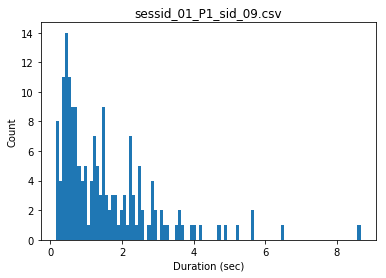

Mean: 2.047325231481476	 Median: 1.2100624999999887
Min: 0.20999999999997954	 Max: 10.160124999999994


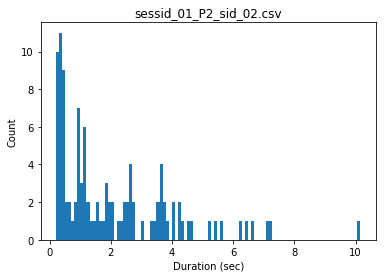

Mean: 2.034204234972674	 Median: 1.5101249999999595
Min: 0.2301249999999868	 Max: 8.790124999999989


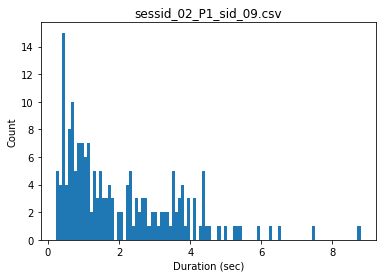

Mean: 1.8570107142857126	 Median: 1.3100624999999795
Min: 0.15012500000000273	 Max: 8.480125000000044


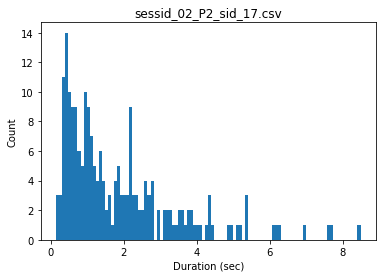

Mean: 2.1811056818181767	 Median: 1.5351249999999936
Min: 0.17012499999999875	 Max: 7.149999999999977


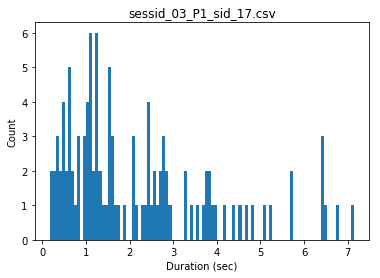

Mean: 1.722984589041094	 Median: 1.2501250000000255
Min: 0.24012499999997772	 Max: 6.960124999999977


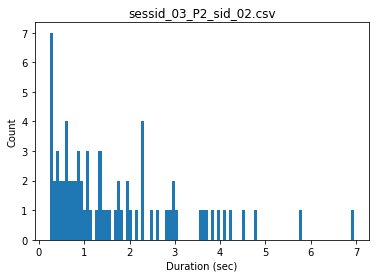

Mean: 2.380828313253008	 Median: 1.1701249999999845
Min: 0.20012499999995725	 Max: 15.019999999999982


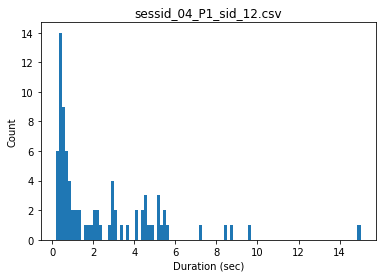

Mean: 2.7295848684210484	 Median: 2.2151250000000005
Min: 0.23012500000004366	 Max: 9.050125000000094


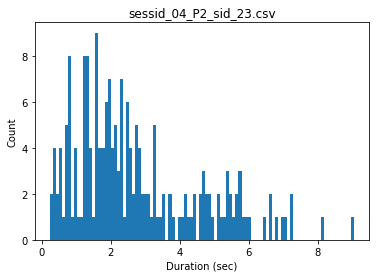

Mean: 2.106815548780483	 Median: 1.0301249999999413
Min: 0.15012500000000273	 Max: 8.339999999999918


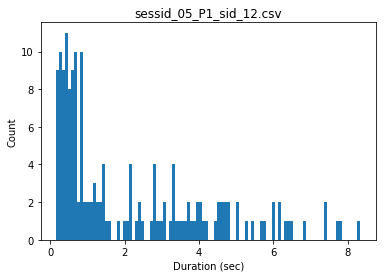

Mean: 2.3594988317756984	 Median: 1.590062500000002
Min: 0.23012500000001523	 Max: 13.990124999999978


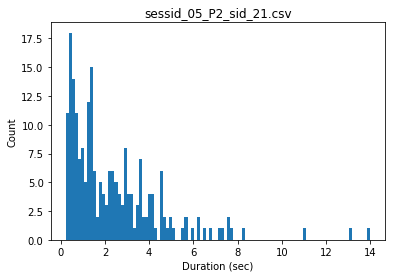

Mean: 1.687834580838325	 Median: 1.1801250000000039
Min: 0.03012499999999818	 Max: 5.810125000000085


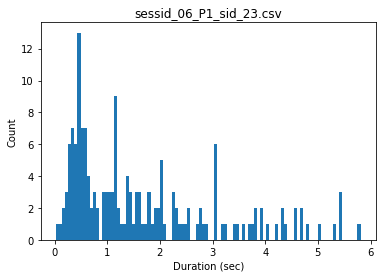

Mean: 2.1358938848920817	 Median: 1.5651249999999752
Min: 0.14012500000001182	 Max: 10.01012499999996


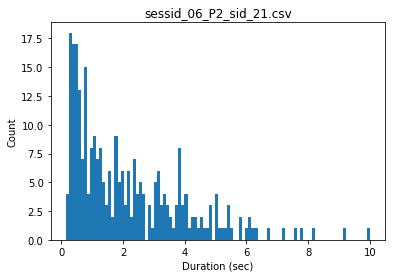

Mean: 1.9548677184465983	 Median: 1.4500625000000298
Min: 0.2001250000000141	 Max: 9.520125000000007


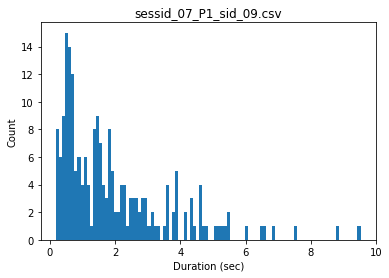

Mean: 2.128895027624304	 Median: 0.9399999999999977
Min: 0.12012499999991633	 Max: 13.030124999999998


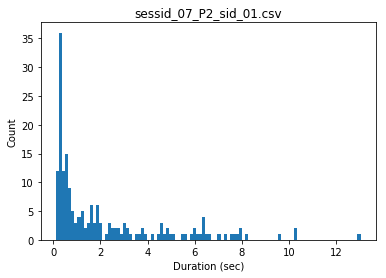

Mean: 1.5079596613545807	 Median: 1.2501250000000255
Min: 0.1001250000000482	 Max: 9.420125000000098


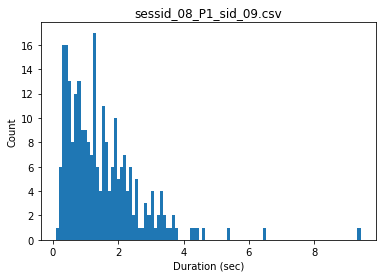

Mean: 1.555372368421051	 Median: 1.2801249999999982
Min: 0.03012499999999818	 Max: 7.210125000000005


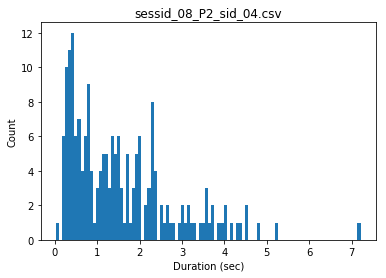

Mean: 1.367902027027027	 Median: 1.0001250000000255
Min: 0.15012500000000273	 Max: 4.900125000000003


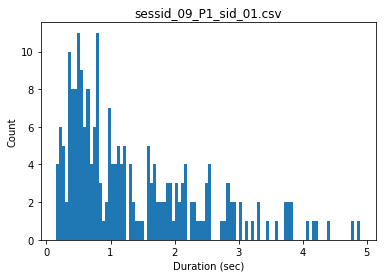

Mean: 1.5309615384615336	 Median: 1.070062499999949
Min: 0.03012499999999818	 Max: 7.890124999999898


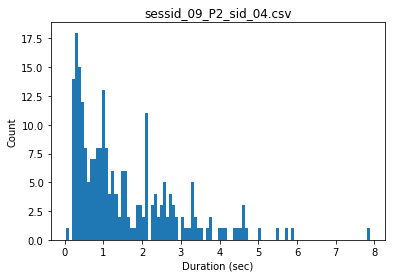

Mean: 1.7843985714285695	 Median: 1.2501250000000255
Min: 0.23012500000001523	 Max: 9.33012500000001


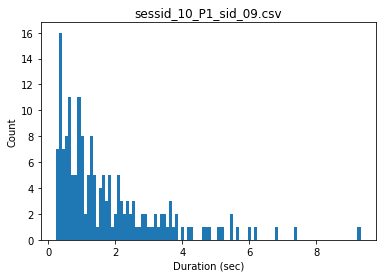

Mean: 3.2248562499999913	 Median: 2.8251249999999573
Min: 0.2701250000000073	 Max: 10.140125000000012


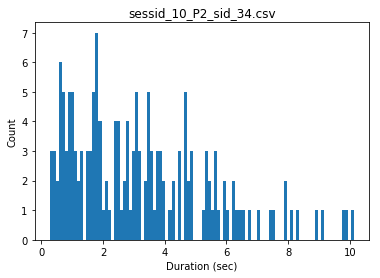

Mean: 1.8744457671957642	 Median: 1.4801249999999868
Min: 0.12012500000003001	 Max: 6.990124999999921


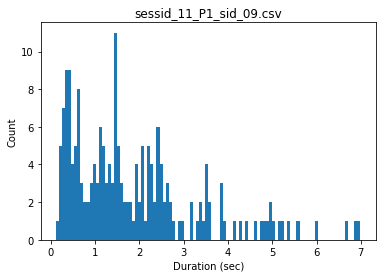

Mean: 1.4410938735177832	 Median: 0.9699999999999989
Min: 0.16012499999999363	 Max: 8.450125000000014


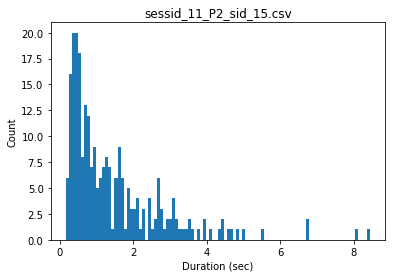

Mean: 1.2983912671232856	 Median: 0.9251250000000084
Min: 0.16012499999999363	 Max: 5.740124999999978


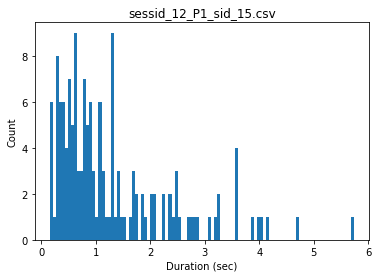

Mean: 2.0366128048780454	 Median: 1.6001249999999914
Min: 0.2201249999999959	 Max: 7.310125000000028


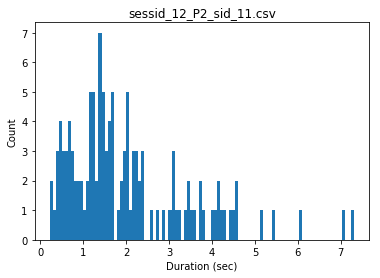

Mean: 1.7143758741258737	 Median: 1.470124999999996
Min: 0.23012500000004366	 Max: 6.05012499999998


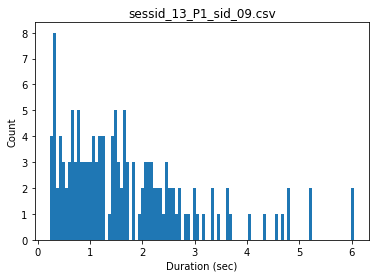

Mean: 2.291526836158186	 Median: 1.9001250000000027
Min: 0.23012500000004366	 Max: 9.280124999999998


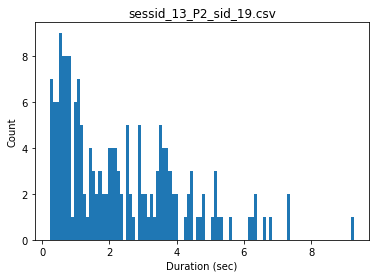

Mean: 1.3599577205882323	 Median: 0.9401249999999877
Min: 0.210125000000005	 Max: 5.770124999999993


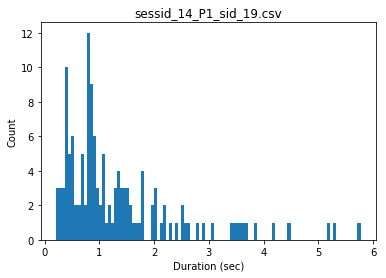

Mean: 2.134636718749995	 Median: 1.6001249999999914
Min: 0.24012499999992087	 Max: 6.810124999999971


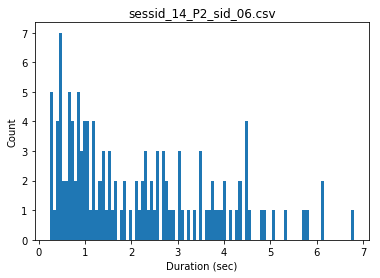

Mean: 1.7801084558823503	 Median: 1.3950624999999945
Min: 0.2301249999999868	 Max: 6.319999999999993


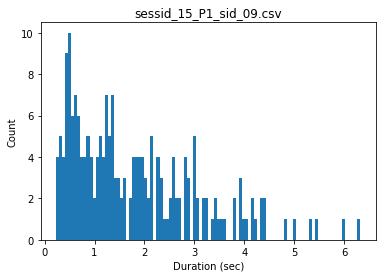

Mean: 2.206311197916669	 Median: 1.7400625000000218
Min: 0.03012499999999818	 Max: 7.960125000000005


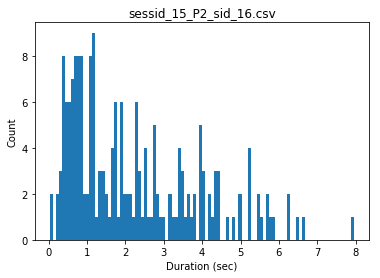

Mean: 1.5203194742489197	 Median: 1.1001250000000198
Min: 0.06012500000002774	 Max: 9.290124999999989


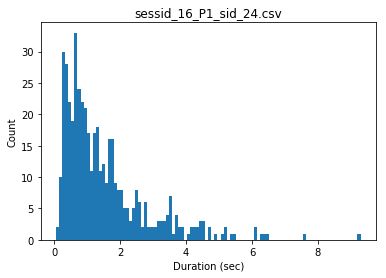

Mean: 1.3733848484848472	 Median: 1.0001249999999686
Min: 0.2899999999999636	 Max: 5.400125000000003


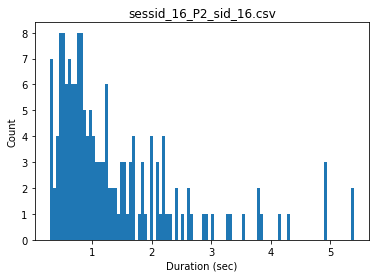

Mean: 1.4731040145985368	 Median: 1.0601250000000277
Min: 0.17012499999998454	 Max: 8.170124999999985


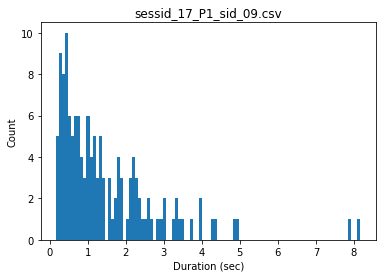

Mean: 1.6651770833333335	 Median: 1.3501249999999345
Min: 0.1599999999999966	 Max: 5.7501250000000255


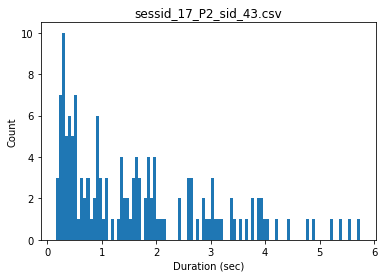

Mean: 1.5787493206521732	 Median: 1.1251250000000113
Min: 0.18012499999998965	 Max: 5.820125000000004


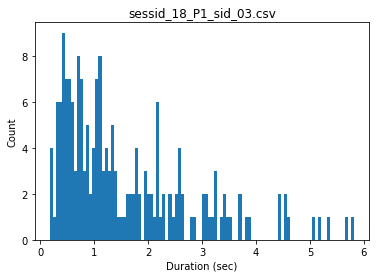

Mean: 1.2421693262411315	 Median: 0.5201250000000073
Min: 0.18012499999997544	 Max: 6.350124999999991


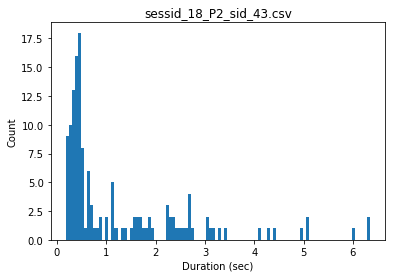

Mean: 1.6947832661290307	 Median: 1.1451250000000641
Min: 0.17999999999994998	 Max: 8.340125000000057


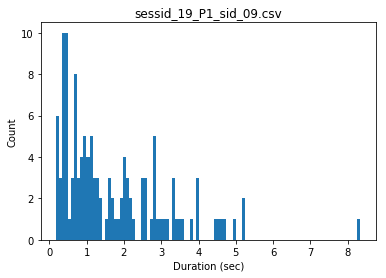

Mean: 2.462971540178569	 Median: 1.8601250000000107
Min: 0.21012500000006185	 Max: 10.170124999999985


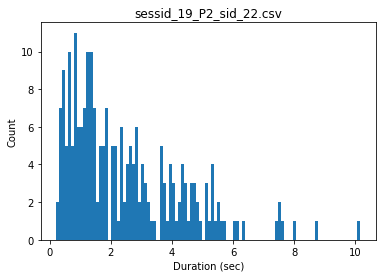

Mean: 1.6906509009008945	 Median: 1.3501249999999914
Min: 0.22012499999999946	 Max: 6.050125000000094


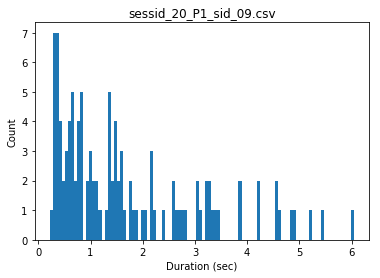

Mean: 2.933544378698226	 Median: 2.4901250000000346
Min: 0.19012499999996635	 Max: 14.159999999999968


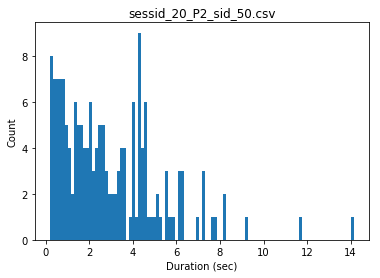

Mean: 2.6665309633027467	 Median: 1.9301249999999754
Min: 0.2801250000000053	 Max: 10.30012499999998


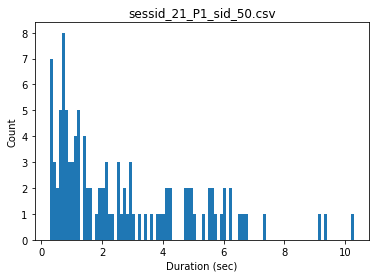

Mean: 2.348897629310342	 Median: 1.8801249999999956
Min: 0.19999999999998863	 Max: 8.730125000000044


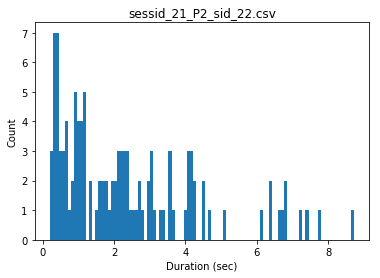

Mean: 2.368246527777774	 Median: 1.3999999999999773
Min: 0.15012500000000273	 Max: 9.610124999999925


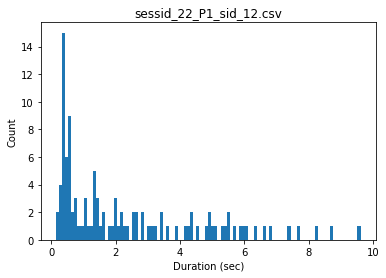

Mean: 1.883920594262294	 Median: 1.4851249999999823
Min: 0.2001250000000141	 Max: 10.310125000000028


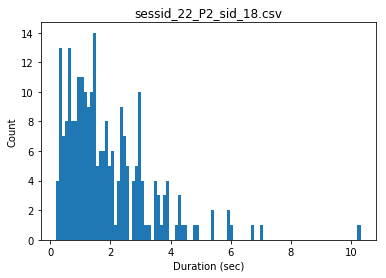

Mean: 2.1926085069444423	 Median: 1.6801250000000039
Min: 0.15012500000000273	 Max: 10.210125000000005


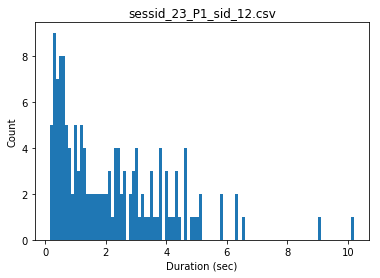

Mean: 1.780517045454541	 Median: 1.450125000000007
Min: 0.20012499999995725	 Max: 9.230124999999987


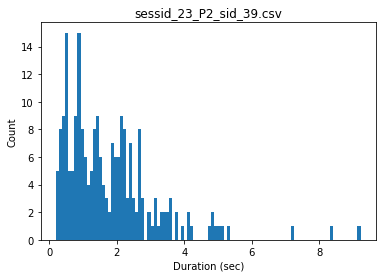

Mean: 1.5212308467741902	 Median: 1.1101250000000098
Min: 0.16012500000002206	 Max: 8.180124999999975


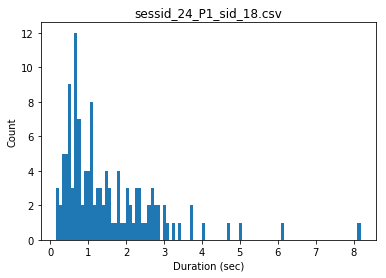

Mean: 1.608195224719099	 Median: 1.1301249999999925
Min: 0.2201249999999959	 Max: 6.000124999999997


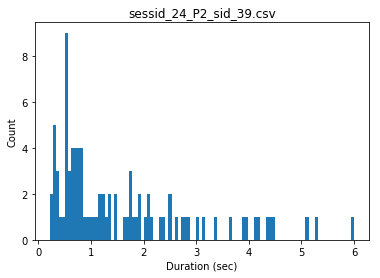

Mean: 2.571960648148149	 Median: 2.1001249999999914
Min: 0.20999999999999375	 Max: 8.74012499999992


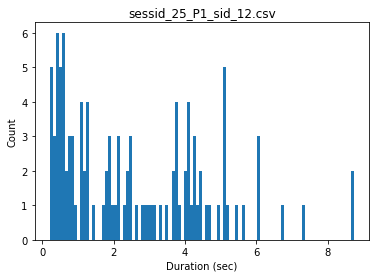

Mean: 2.020485937499996	 Median: 1.65006249999999
Min: 0.3601249999999254	 Max: 7.070125000000001


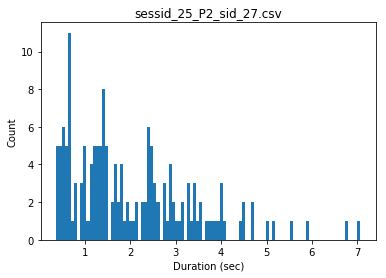

Mean: 2.0108472222222202	 Median: 1.6501250000000027
Min: 0.2001249999999999	 Max: 7.240124999999978


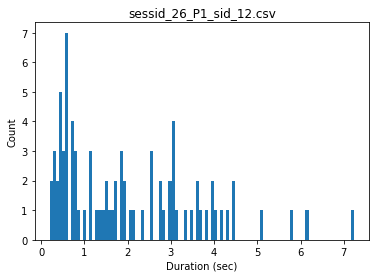

Mean: 1.3181439606741545	 Median: 0.8901250000000118
Min: 0.03012499999999818	 Max: 8.400125000000003


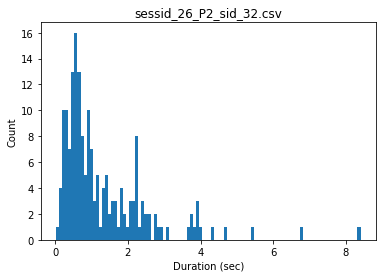

Mean: 2.0000162037037006	 Median: 1.225124999999995
Min: 0.03012499999999818	 Max: 9.930125000000032


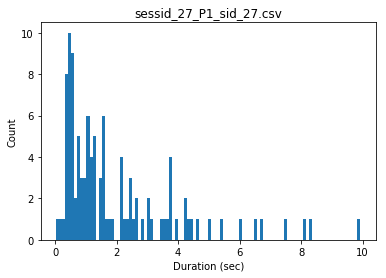

Mean: 1.5991573275862039	 Median: 1.1150625000000103
Min: 0.21012499999994816	 Max: 9.299999999999983


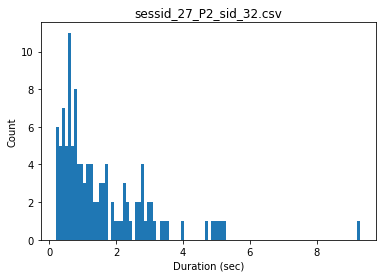

Mean: 1.9958757763975106	 Median: 1.5201250000000073
Min: 0.2201249999999959	 Max: 10.890125000000012


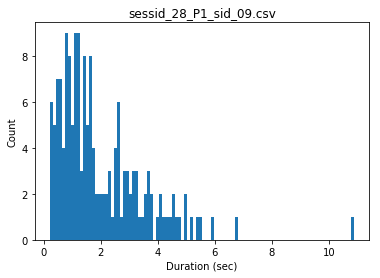

Mean: 2.0198807077625602	 Median: 1.5301249999999982
Min: 0.18012499999997544	 Max: 11.87012500000003


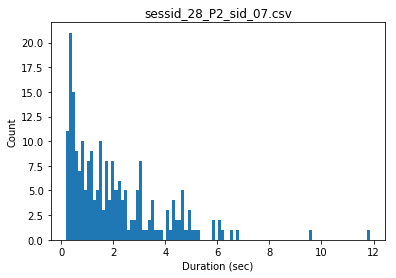

Mean: 1.5760053956834457	 Median: 1.2101249999999482
Min: 0.1901250000000232	 Max: 6.5001250000000255


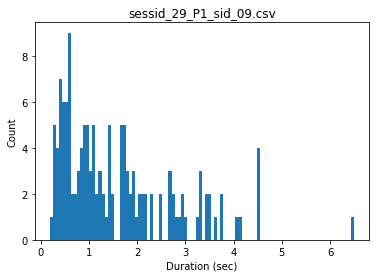

Mean: 1.6540378989361653	 Median: 1.27506249999999
Min: 0.03012499999999818	 Max: 9.770124999999993


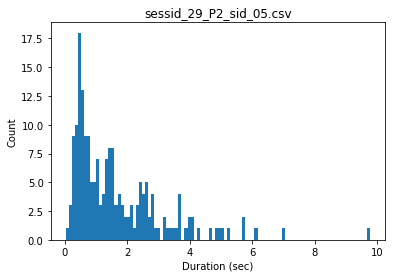

Mean: 1.623173469387755	 Median: 1.0801250000000024
Min: 0.259999999999998	 Max: 6.5901250000000005


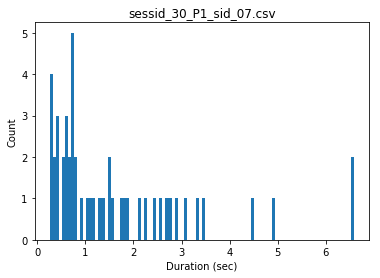

Mean: 1.969457446808509	 Median: 1.2101249999999997
Min: 0.06012499999999932	 Max: 9.029999999999994


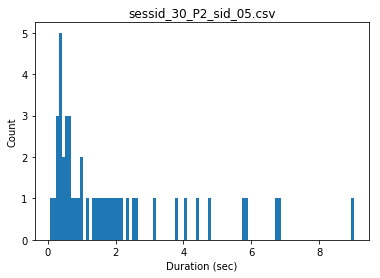

Mean: 1.8342941176470533	 Median: 1.4601249999999482
Min: 0.03012499999999818	 Max: 6.730125000000001


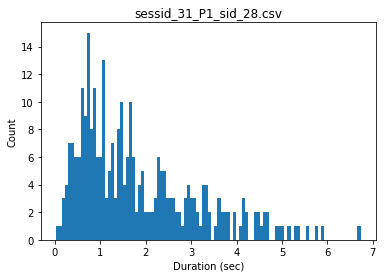

Mean: 1.2684587378640773	 Median: 0.80012499999998
Min: 0.03012499999999818	 Max: 6.5101249999999595


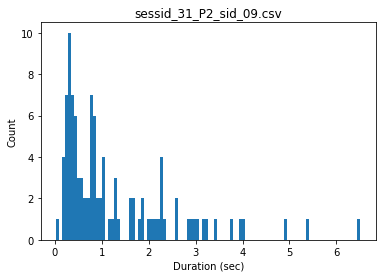

Mean: 1.3752370466321218	 Median: 0.9501249999999999
Min: 0.1801250000000323	 Max: 5.850124999999991


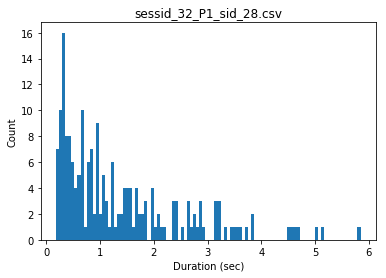

Mean: 1.4539544871794843	 Median: 0.7801249999999982
Min: 0.1301249999999925	 Max: 10.080124999999953


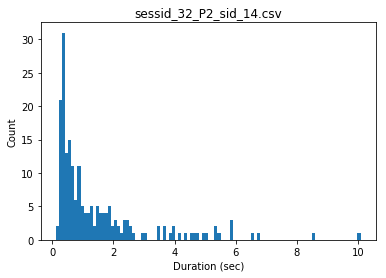

Mean: 1.284952044025157	 Median: 0.8901250000000118
Min: 0.03012499999999818	 Max: 7.73012499999993


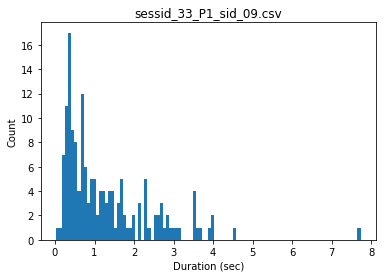

Mean: 1.9020212765957414	 Median: 1.4901249999999777
Min: 0.20999999999997954	 Max: 9.810124999999971


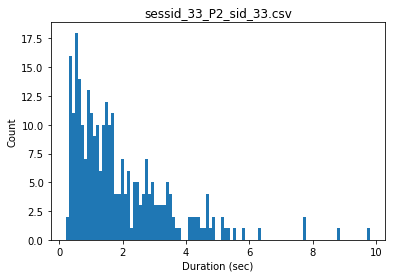

Mean: 1.5101019345238005	 Median: 1.0801250000000238
Min: 0.15012500000000273	 Max: 4.940124999999966


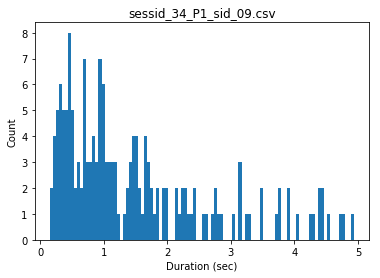

Mean: 1.6415580912863057	 Median: 1.2699999999999818
Min: 0.07012499999999022	 Max: 6.530124999999998


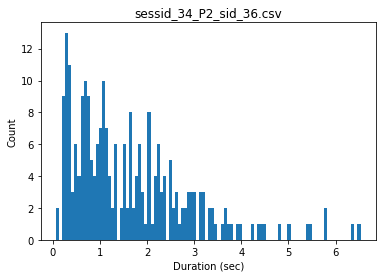

Mean: 1.6551334080717448	 Median: 1.3001250000000937
Min: 0.13999999999998636	 Max: 7.310125000000085


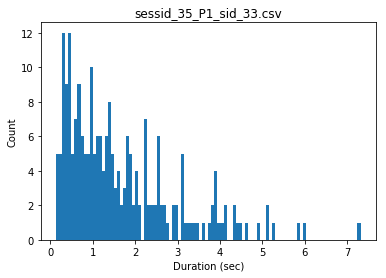

Mean: 1.5490718884120112	 Median: 1.23012499999993
Min: 0.2201249999999959	 Max: 5.540124999999989


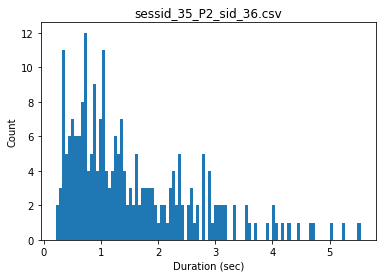

Mean: 1.7503297101449193	 Median: 0.8551250000000152
Min: 0.17012499999998454	 Max: 12.720124999999996


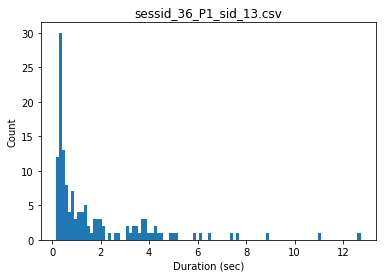

Mean: 1.4063872807017526	 Median: 1.1501250000000027
Min: 0.12000000000000455	 Max: 7.850124999999991


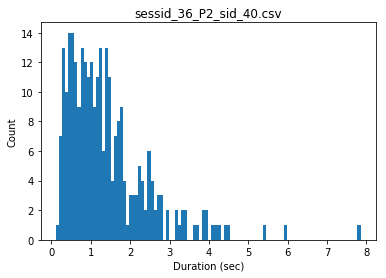

Mean: 1.342202956989243	 Median: 0.8451250000000243
Min: 0.029999999999997584	 Max: 7.829999999999984


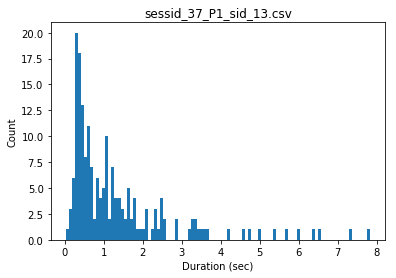

Mean: 1.8738527397260247	 Median: 1.3401250000000005
Min: 0.20999999999997954	 Max: 9.660124999999994


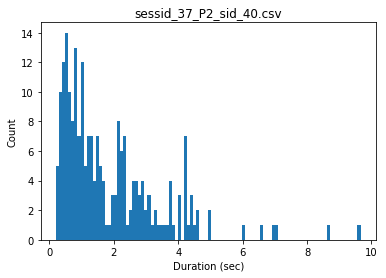

Mean: 2.149153138528134	 Median: 1.8099999999999454
Min: 0.2801249999999982	 Max: 7.8501249999999345


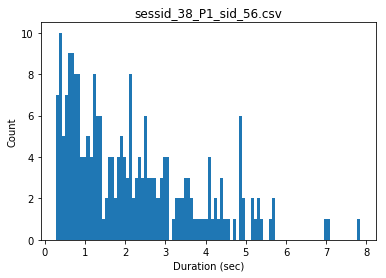

Mean: 2.315879353233831	 Median: 1.75
Min: 0.15012499999988904	 Max: 9.440124999999966


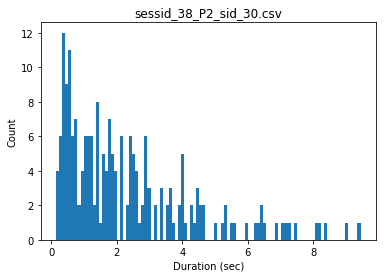

Mean: 2.0429093749999994	 Median: 1.7800624999999854
Min: 0.0901250000000573	 Max: 7.4201249999999845


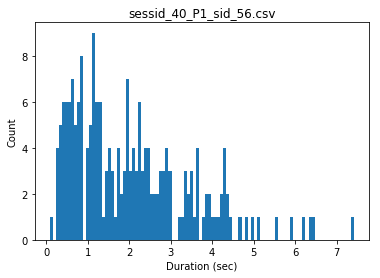

Mean: 1.6473971962616796	 Median: 1.2701250000000073
Min: 0.14012500000001182	 Max: 6.310124999999999


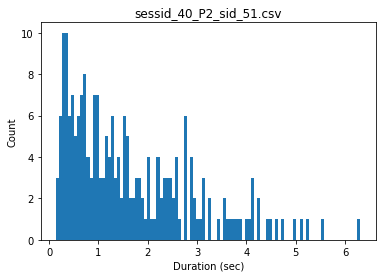

Mean: 2.5183279109589	 Median: 1.5801250000000238
Min: 0.18012499999997544	 Max: 10.840125


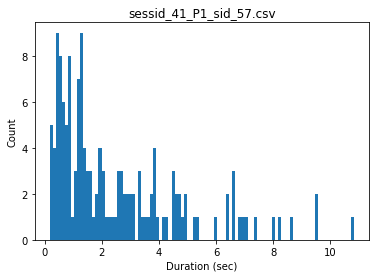

Mean: 1.9907310344827582	 Median: 1.3301250000000095
Min: 0.24012500000003456	 Max: 11.420125000000013


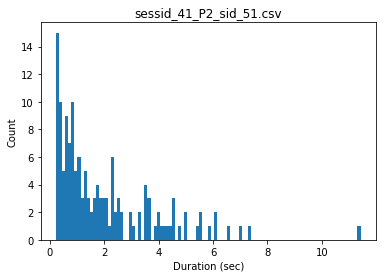

Mean: 1.9017021276595756	 Median: 1.5950624999999832
Min: 0.08012500000000067	 Max: 8.670125000000013


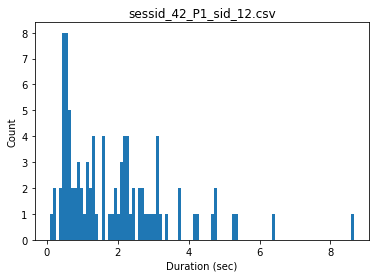

Mean: 2.5068155487804886	 Median: 1.9750624999999502
Min: 0.19012500000000188	 Max: 14.140124999999998


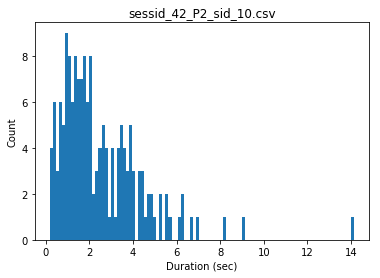

Mean: 2.27941375	 Median: 1.8951249999999789
Min: 0.17012500000009823	 Max: 9.640125000000012


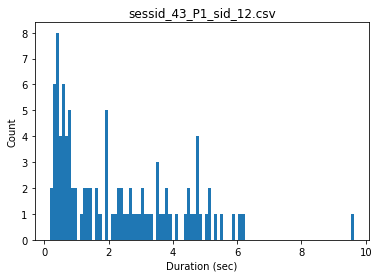

Mean: 2.1630036764705856	 Median: 1.8701250000000158
Min: 0.26012500000001637	 Max: 7.100125000000048


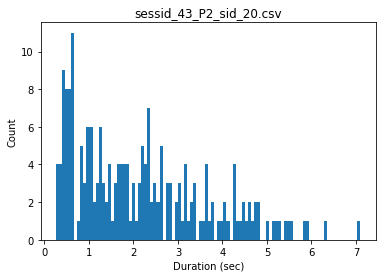

Mean: 1.5195921052631554	 Median: 1.2801249999999982
Min: 0.18012499999999854	 Max: 4.740124999999978


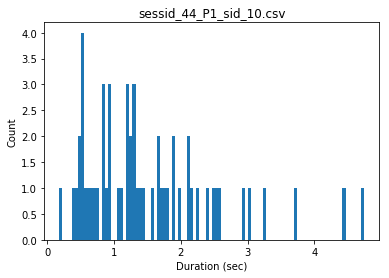

Mean: 2.1908828125	 Median: 1.8401249999999951
Min: 0.41012500000002206	 Max: 5.480125000000001


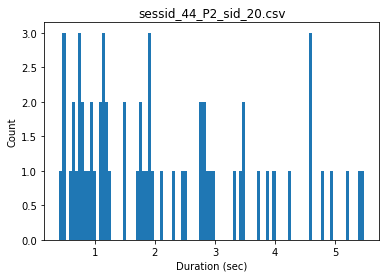

Mean: 2.001672297297295	 Median: 1.5201250000000073
Min: 0.2299999999999045	 Max: 9.090125


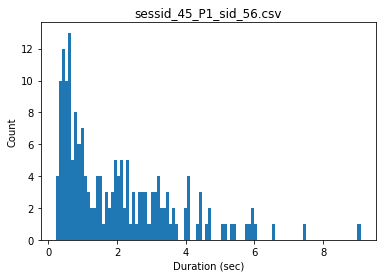

Mean: 2.095295124481322	 Median: 1.7001249999999573
Min: 0.21012500000006185	 Max: 6.690124999999995


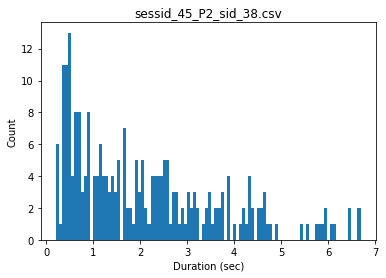

Mean: 2.423446078431373	 Median: 1.950125000000014
Min: 0.3101249999999993	 Max: 8.990125000000006


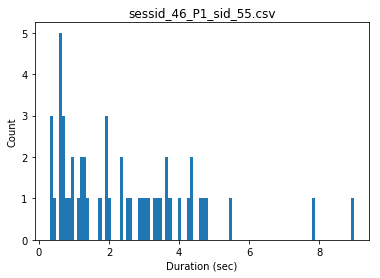

Mean: 2.4228934426229514	 Median: 2.000124999999997
Min: 0.29999999999998295	 Max: 6.060124999999971


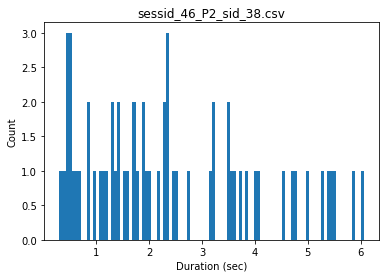

Mean: 2.0955213414634093	 Median: 1.810124999999971
Min: 0.03012499999999818	 Max: 5.780124999999998


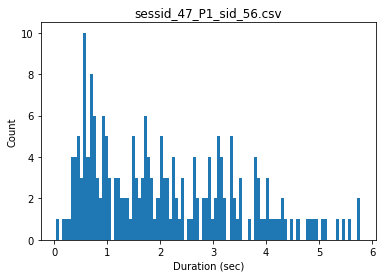

Mean: 1.5023038116591911	 Median: 1.0001249999999686
Min: 0.15012499999994589	 Max: 6.919999999999959


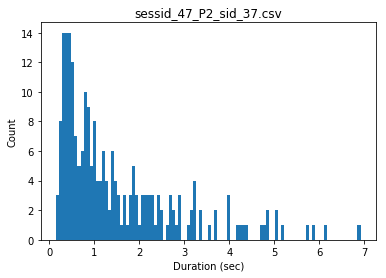

Mean: 1.745246739130434	 Median: 1.3101249999999993
Min: 0.2699999999999818	 Max: 5.5401250000000175


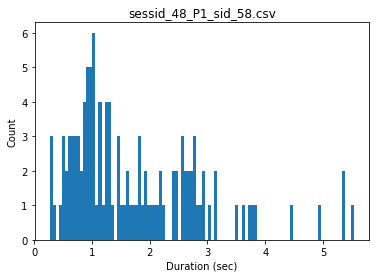

Mean: 1.174109042553187	 Median: 0.7199999999999136
Min: 0.029999999999986926	 Max: 5.939999999999998


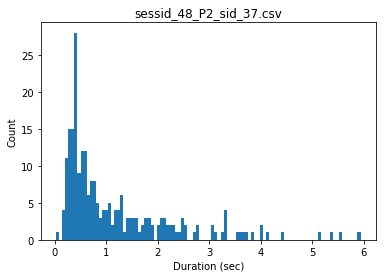

Mean: 1.8445969387755046	 Median: 1.4751250000000198
Min: 0.2001249999999999	 Max: 6.5801250000000095


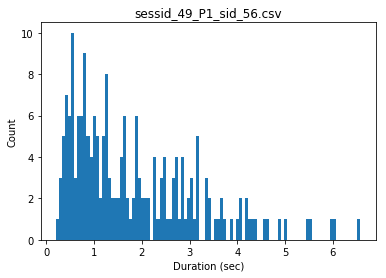

Mean: 1.5763629679144375	 Median: 0.960125000000005
Min: 0.20012499999995725	 Max: 9.780124999999998


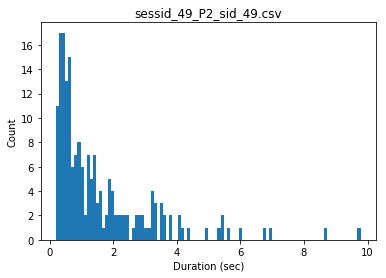

Mean: 2.634702702702698	 Median: 1.9501249999999573
Min: 0.08012499999999889	 Max: 11.070124999999962


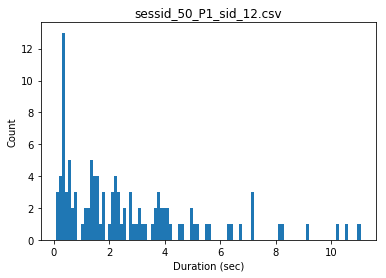

Mean: 1.6462674418604615	 Median: 1.2351250000000036
Min: 0.20012499999995725	 Max: 7.780124999999998


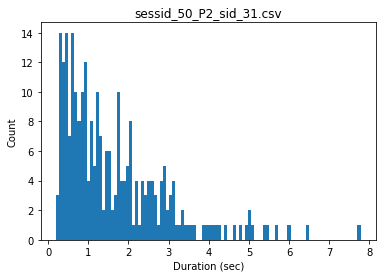

Mean: 1.859156250000002	 Median: 1.0751249999999999
Min: 0.1901250000000232	 Max: 6.6701249999999845


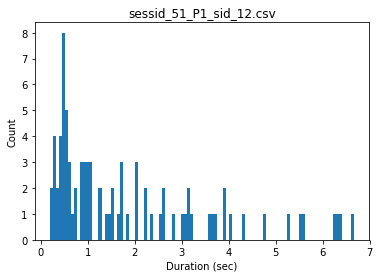

Mean: 2.8028641304347763	 Median: 2.0501250000000084
Min: 0.2501249999999118	 Max: 11.310125


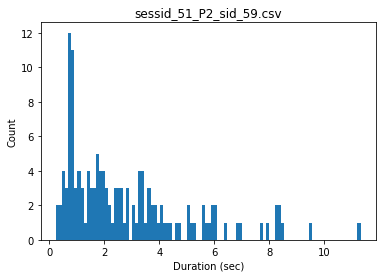

Mean: 2.3216003086419734	 Median: 2.0901250000000573
Min: 0.3201249999999618	 Max: 7.770125000000007


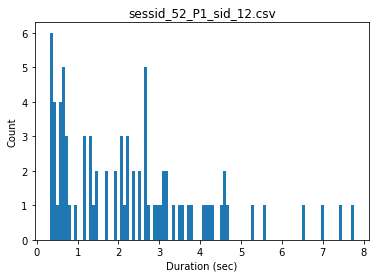

Mean: 2.0851813380281694	 Median: 1.6051250000000437
Min: 0.25012499999999704	 Max: 8.58012500000001


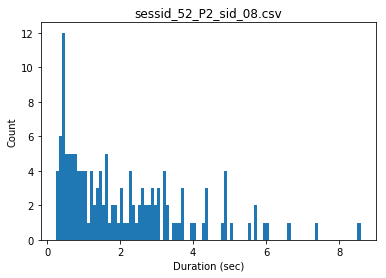

Mean: 2.149898936170211	 Median: 1.610125
Min: 0.42012499999999875	 Max: 6.230125000000044


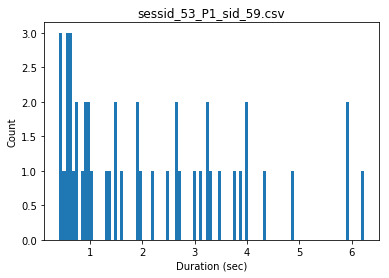

Mean: 1.4159975490196075	 Median: 0.9701250000000066
Min: 0.2001249999999999	 Max: 8.280124999999998


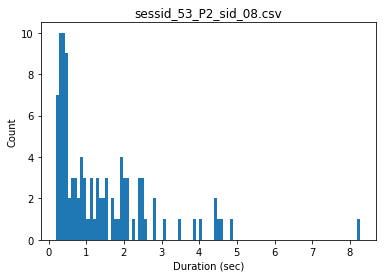

Mean: 2.259578947368422	 Median: 1.5051250000000067
Min: 0.14012500000001182	 Max: 7.720125000000053


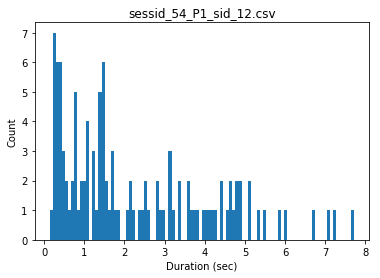

Mean: 2.1630613207547134	 Median: 1.470124999999996
Min: 0.029999999999972715	 Max: 10.05012499999998


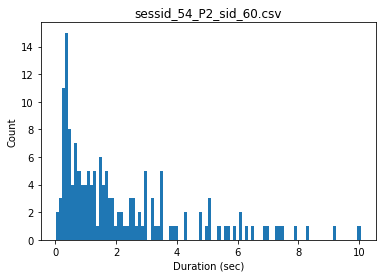

In [4]:
###################################################################################################
# Plot distributions of durations of voice-active intervals (after the above smoothing)
###################################################################################################

import json
import glob
import numpy as np
import pandas as pd
import soundfile as sf
from matplotlib import pyplot as plt


# Path to VA intervals
voice_activity_dir = f'/home/ICT2000/jondras/dvra_datasets/mimicry/voice_activity_detection/voice_activity_ibm_watson'

for i, voice_activity_file in enumerate(sorted(glob.glob(f'{voice_activity_dir}/*.csv'))):
    df = pd.read_csv(voice_activity_file)
    durations = df['end_time'] - df['start_time']

    bins_range = 100

    print(f'Mean: {np.mean(durations)}\t Median: {np.median(durations)}')
    print(f'Min: {np.min(durations)}\t Max: {np.max(durations)}')
    plt.figure()
    plt.title(voice_activity_file.split('/')[-1])
    plt.hist(durations, bins=bins_range)
    plt.xlabel('Duration (sec)')
    plt.ylabel('Count')
    plt.show()
    plt.close()